# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sns.set()

# magic word for producing visualizations in notebook
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.expand_frame_repr', False)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [4]:
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.000,3,4,3,5,5,3,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,-1,1,2,5.000,1,5,2,5,4,5,...,2.000,3.000,2.000,1.000,1.000,5.000,4.000,3.000,5.000,4.000
2,-1,3,2,3.000,1,4,1,2,3,5,...,3.000,3.000,1.000,0.000,1.000,4.000,4.000,3.000,5.000,2.000
3,2,4,2,2.000,4,2,5,2,1,2,...,2.000,2.000,2.000,0.000,1.000,3.000,4.000,2.000,3.000,3.000
4,-1,3,1,5.000,4,3,4,1,3,2,...,2.000,4.000,2.000,1.000,2.000,3.000,3.000,4.000,6.000,5.000


In [42]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000,891221.000,891221.000,886367.000,891221.000,891221.000,891221.000,891221.000,891221.000,891221.000,...,774706.000,774706.000,774706.000,774706.000,774706.000,774706.000,774706.000,794005.000,794005.000,794005.000
mean,-0.358,2.777,1.522,3.633,3.075,2.821,3.401,3.033,2.874,3.075,...,2.253,2.802,1.595,0.699,1.944,3.613,3.381,3.168,5.293,3.072
std,1.199,1.069,0.500,1.595,1.321,1.465,1.322,1.530,1.487,1.353,...,0.972,0.920,0.987,0.727,1.460,0.974,1.112,1.002,2.304,1.363
min,-1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,1.000
25%,-1.000,2.000,1.000,2.000,2.000,1.000,3.000,2.000,2.000,2.000,...,1.000,2.000,1.000,0.000,1.000,3.000,3.000,3.000,4.000,2.000
50%,-1.000,3.000,2.000,4.000,3.000,3.000,3.000,3.000,3.000,3.000,...,2.000,3.000,2.000,1.000,1.000,4.000,3.000,3.000,5.000,3.000
75%,-1.000,4.000,2.000,5.000,4.000,4.000,5.000,5.000,4.000,4.000,...,3.000,3.000,2.000,1.000,3.000,4.000,4.000,4.000,7.000,4.000
max,3.000,9.000,2.000,6.000,5.000,5.000,5.000,5.000,5.000,5.000,...,4.000,4.000,3.000,2.000,5.000,5.000,5.000,9.000,9.000,9.000


In [6]:
feat_info.query('attribute == "ORTSGR_KLS9"')

,attribute,information_level,type,missing_or_unknown
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [3]:
azdias.query('ORTSGR_KLS9 == 9')['ORTSGR_KLS9']

36       9.000
52       9.000
63       9.000
74       9.000
82       9.000
84       9.000
139      9.000
147      9.000
156      9.000
182      9.000
197      9.000
200      9.000
206      9.000
207      9.000
212      9.000
218      9.000
220      9.000
222      9.000
298      9.000
304      9.000
321      9.000
333      9.000
352      9.000
359      9.000
375      9.000
386      9.000
401      9.000
429      9.000
431      9.000
432      9.000
          ... 
890907   9.000
890918   9.000
890948   9.000
890958   9.000
890959   9.000
890976   9.000
890980   9.000
891018   9.000
891058   9.000
891060   9.000
891065   9.000
891066   9.000
891067   9.000
891085   9.000
891094   9.000
891102   9.000
891103   9.000
891109   9.000
891110   9.000
891116   9.000
891138   9.000
891141   9.000
891142   9.000
891153   9.000
891163   9.000
891180   9.000
891197   9.000
891198   9.000
891210   9.000
891212   9.000
Name: ORTSGR_KLS9, Length: 91879, dtype: float64

In [13]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.000,3,4,3,5,5,3,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,-1,1,2,5.000,1,5,2,5,4,5,...,2.000,3.000,2.000,1.000,1.000,5.000,4.000,3.000,5.000,4.000
2,-1,3,2,3.000,1,4,1,2,3,5,...,3.000,3.000,1.000,0.000,1.000,4.000,4.000,3.000,5.000,2.000
3,2,4,2,2.000,4,2,5,2,1,2,...,2.000,2.000,2.000,0.000,1.000,3.000,4.000,2.000,3.000,3.000
4,-1,3,1,5.000,4,3,4,1,3,2,...,2.000,4.000,2.000,1.000,2.000,3.000,3.000,4.000,6.000,5.000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
# Identify missing or unknown data values and convert them to NaNs.
nan = ['[',',',']']
column_nans = feat_info['missing_or_unknown'].str.replace('[','').str.replace(']', '').str.split(',').values
m = pd.DataFrame(columns = ['null'],data = column_nans, index = feat_info['attribute'])
m

,null
attribute,
AGER_TYP,"[-1, 0]"
ALTERSKATEGORIE_GROB,"[-1, 0, 9]"
ANREDE_KZ,"[-1, 0]"
CJT_GESAMTTYP,[0]
FINANZ_MINIMALIST,[-1]
FINANZ_SPARER,[-1]
FINANZ_VORSORGER,[-1]
FINANZ_ANLEGER,[-1]
FINANZ_UNAUFFAELLIGER,[-1]


In [4]:
def is_a_number(string):
    numbers = list(range(-1,20))
    n_numbers = []
    for i in numbers:
        n_numbers.append(str(i))
    if string in n_numbers:
        return True
    else:
        return False

print(is_a_number('-1'))

True


In [5]:
m['null'] = m.apply(lambda x: [int(i) if is_a_number(i) == True else i for i in x[0]], axis=1)
m

,null
attribute,
AGER_TYP,"[-1, 0]"
ALTERSKATEGORIE_GROB,"[-1, 0, 9]"
ANREDE_KZ,"[-1, 0]"
CJT_GESAMTTYP,[0]
FINANZ_MINIMALIST,[-1]
FINANZ_SPARER,[-1]
FINANZ_VORSORGER,[-1]
FINANZ_ANLEGER,[-1]
FINANZ_UNAUFFAELLIGER,[-1]


In [6]:
for i in azdias.columns:
    azdias[i] = azdias[i].replace(m.loc[i][0], np.nan)

In [40]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,nan,2.000,1,2.000,3,4,3,5,5,3,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,1.000,2,5.000,1,5,2,5,4,5,...,2.000,3.000,2.000,1.000,1.000,5.000,4.000,3.000,5.000,4.000
2,nan,3.000,2,3.000,1,4,1,2,3,5,...,3.000,3.000,1.000,0.000,1.000,4.000,4.000,3.000,5.000,2.000
3,2.000,4.000,2,2.000,4,2,5,2,1,2,...,2.000,2.000,2.000,0.000,1.000,3.000,4.000,2.000,3.000,3.000
4,nan,3.000,1,5.000,4,3,4,1,3,2,...,2.000,4.000,2.000,1.000,2.000,3.000,3.000,4.000,6.000,5.000


In [7]:
#sanity check
azdias['ORTSGR_KLS9'][36]

9.0

In [42]:
#sanity check
azdias['TITEL_KZ'].head(15)

0    nan
1    nan
2    nan
3    nan
4    nan
5    nan
6    nan
7    nan
8    nan
9    nan
10   nan
11   nan
12   nan
13   nan
14   nan
Name: TITEL_KZ, dtype: float64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
size = azdias.shape[0]
size

891221

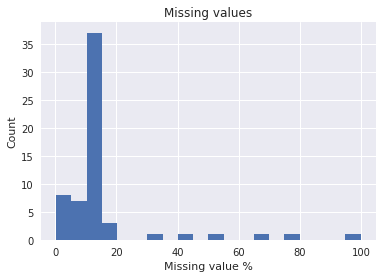

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
m = azdias.isnull().sum().sort_values(ascending = False)
m = m[m > 0]/(size)*100

plt.hist(m, bins=20)
plt.xlabel('Missing value %')
plt.ylabel('Count')
plt.title('Missing values')
plt.show()

In [14]:
#columns with missing values
len(m)

61

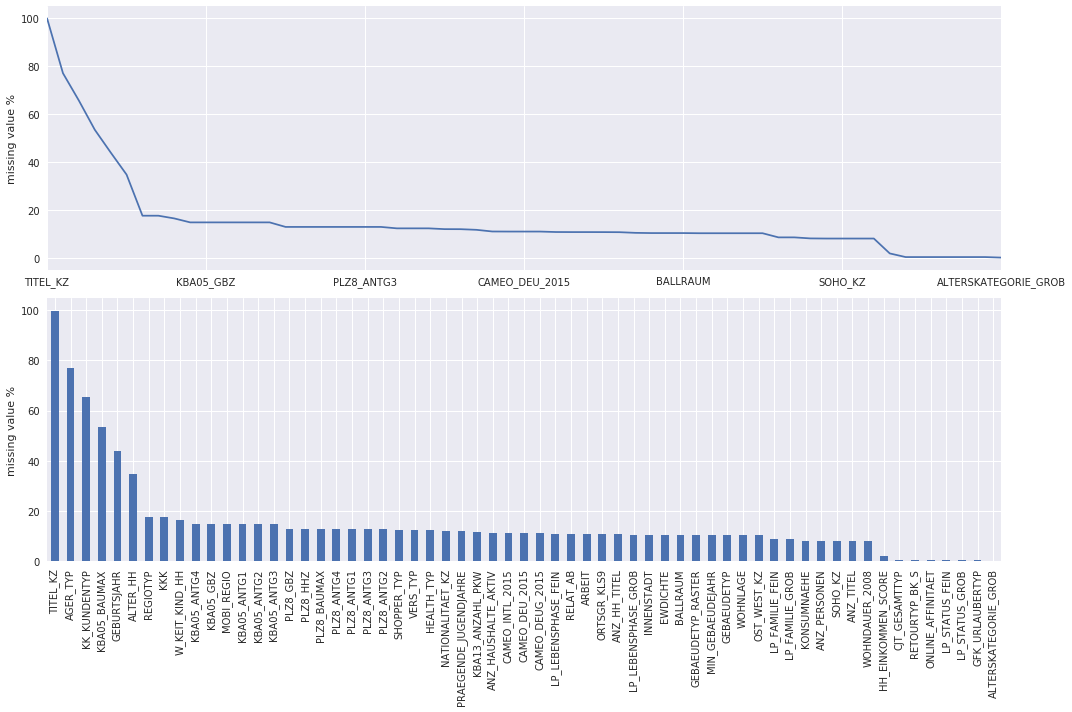

In [10]:
plt.subplot(2,1,1)
m.plot(figsize=(15,10))
plt.ylabel('missing value %')
plt.subplot(2,1,2)
m.plot.bar(figsize=(15,10))
plt.ylabel('missing value %')
plt.tight_layout()

In [11]:
i = m.index
col_name = []
prop = []

for value in m:
    prop.append(value)
for index in i:
    col_name.append(index)

z = pd.DataFrame(columns = ['Prop'], index = col_name, data = prop)
print(z)

                        Prop
TITEL_KZ              99.758
AGER_TYP              76.955
KK_KUNDENTYP          65.597
KBA05_BAUMAX          53.469
GEBURTSJAHR           44.020
ALTER_HH              34.814
REGIOTYP              17.736
KKK                   17.736
W_KEIT_KIND_HH        16.605
KBA05_ANTG4           14.960
KBA05_GBZ             14.960
MOBI_REGIO            14.960
KBA05_ANTG1           14.960
KBA05_ANTG2           14.960
KBA05_ANTG3           14.960
PLZ8_GBZ              13.074
PLZ8_HHZ              13.074
PLZ8_BAUMAX           13.074
PLZ8_ANTG4            13.074
PLZ8_ANTG1            13.074
PLZ8_ANTG3            13.074
PLZ8_ANTG2            13.074
SHOPPER_TYP           12.477
VERS_TYP              12.477
HEALTH_TYP            12.477
NATIONALITAET_KZ      12.154
PRAEGENDE_JUGENDJAHRE 12.137
KBA13_ANZAHL_PKW      11.871
ANZ_HAUSHALTE_AKTIV   11.177
CAMEO_INTL_2015       11.148
...                      ...
CAMEO_DEUG_2015       11.148
LP_LEBENSPHASE_FEIN   10.955
RELAT_AB      

In [12]:
cols_to_drop = z.query('Prop >= 20').index
cols_to_drop

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias1 = azdias.drop(cols_to_drop, axis = 1)

In [19]:
print(azdias1.shape)
azdias1.head()

(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.000,1,2.000,3,4,3,5,5,3,4,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1.000,2,5.000,1,5,2,5,4,5,1,...,2.000,3.000,2.000,1.000,1.000,5.000,4.000,3.000,5.000,4.000
2,3.000,2,3.000,1,4,1,2,3,5,1,...,3.000,3.000,1.000,0.000,1.000,4.000,4.000,3.000,5.000,2.000
3,4.000,2,2.000,4,2,5,2,1,2,6,...,2.000,2.000,2.000,0.000,1.000,3.000,4.000,2.000,3.000,3.000
4,3.000,1,5.000,4,3,4,1,3,2,5,...,2.000,4.000,2.000,1.000,2.000,3.000,3.000,4.000,6.000,5.000


In [22]:
azdias1.to_csv('azdias2.csv', sep = ';', index = False)

In [23]:
azdias1 = pd.read_csv('azdias2.csv', sep = ';')

#### Discussion 1.1.2: Assess Missing Data in Each Column

- Most of the missing data is located after the 20% mark, in the histogram above we can clearly observe this, so the columns contained after this mark can be considered as outliers. 
- In order to see this behaviour better in the following graph we can observe the trend and correctly classify the 6 outliers: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH'].

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
m = azdias1.isnull().sum(axis=1)

Text(0.5,1,'Missing values')

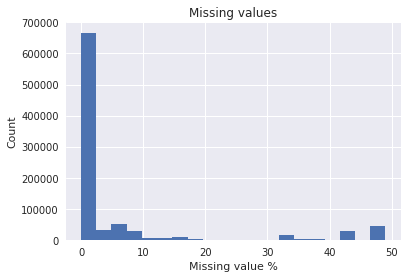

In [15]:
plt.hist(m, bins=20)
plt.xlabel('Missing value %')
plt.ylabel('Count')
plt.title('Missing values')

In [21]:
pd.Series(m).describe()

count   891221.000
mean         5.650
std         13.235
min          0.000
25%          0.000
50%          0.000
75%          3.000
max         49.000
dtype: float64

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Picking the 75% mark

eg = azdias1
eg = eg.assign(missrows = azdias1.isnull().sum(axis=1))
subset1 = eg.query('missrows <= 3')
subset2 = eg.query('missrows > 3')

In [53]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

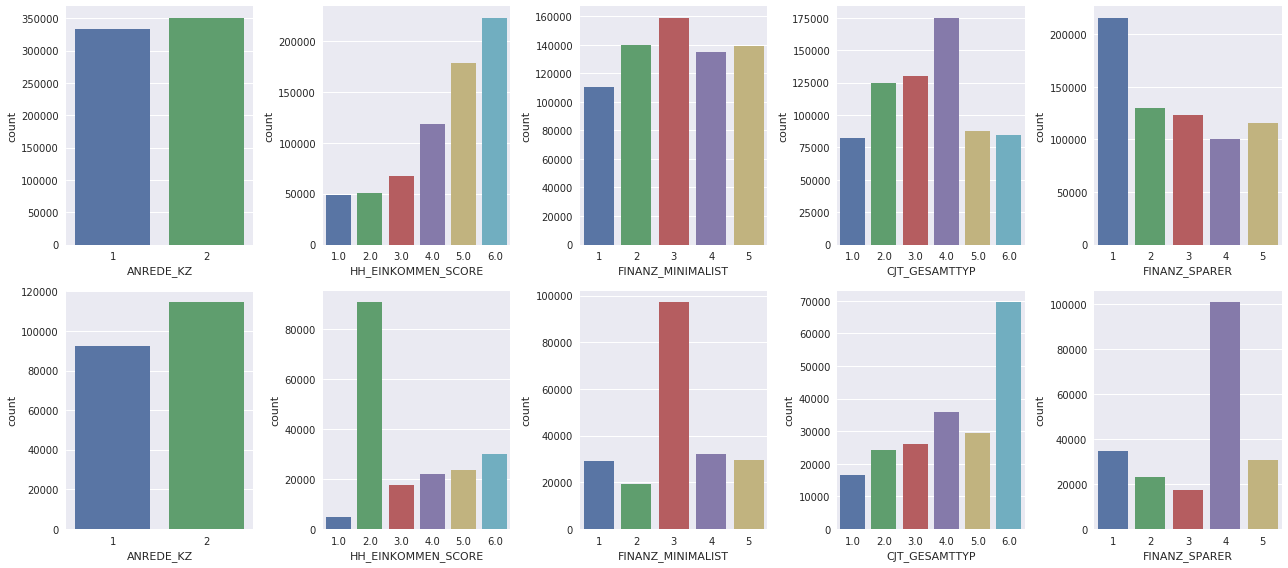

In [23]:
fig, axs = plt.subplots(2,5, figsize=(18,8))
sns.countplot(subset1['ANREDE_KZ'], ax = axs[0,0])
sns.countplot(subset1['HH_EINKOMMEN_SCORE'], ax = axs[0,1])
sns.countplot(subset1['FINANZ_MINIMALIST'], ax = axs[0,2])
sns.countplot(subset1['CJT_GESAMTTYP'], ax = axs[0,3])
sns.countplot(subset1['FINANZ_SPARER'], ax = axs[0,4])
sns.countplot(subset2['ANREDE_KZ'], ax = axs[1,0])
sns.countplot(subset2['HH_EINKOMMEN_SCORE'], ax = axs[1,1])
sns.countplot(subset2['FINANZ_MINIMALIST'], ax = axs[1,2])
sns.countplot(subset2['CJT_GESAMTTYP'], ax = axs[1,3])
sns.countplot(subset2['FINANZ_SPARER'], ax = axs[1,4])
plt.tight_layout()
plt.show()

In [25]:
df = subset1
df.drop('missrows', axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
df.shape

(684502, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- Looking at the counplots the distributions of the columns are quite different, except for the binary feature, so from the previous analysis the best decision would have been dropping these variables. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
# How many features are there of each data type?
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [32]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [33]:
nf = pd.DataFrame(columns = ['Type'], index = feat_info['attribute'], data = feat_info['type'].values)

In [34]:
nf.drop(cols_to_drop, axis = 0, inplace = True)

In [36]:
print(len(nf.query('Type == "categorical"').index))
nf.query('Type == "categorical"').index

18


Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object', name='attribute')

In [37]:
df[['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']].describe()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP
count,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000,684502.000
mean,1.512,3.460,3.914,7.451,0.228,3.940,2.386,4.744,2.450,1.167,1.555,0.008,1.529,3.383,2.834
std,0.500,1.526,2.082,3.538,0.419,3.962,1.708,3.530,1.514,0.472,1.024,0.091,0.499,1.411,2.684
min,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,1.000
25%,1.000,2.000,2.000,4.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,3.000,1.000
50%,2.000,4.000,5.000,8.000,0.000,1.000,1.000,4.000,2.000,1.000,2.000,0.000,2.000,3.000,1.000
75%,2.000,5.000,6.000,11.000,0.000,9.000,5.000,9.000,4.000,1.000,2.000,0.000,2.000,4.000,3.000
max,2.000,6.000,6.000,12.000,1.000,11.000,5.000,10.000,5.000,3.000,3.000,1.000,2.000,6.000,8.000


In [38]:
#describe did not showed these two
df[['OST_WEST_KZ','CAMEO_DEU_2015']].head()

,OST_WEST_KZ,CAMEO_DEU_2015
1,W,8A
2,W,4C
4,W,6B
5,W,8C
6,W,4A


In [39]:
for c in ['OST_WEST_KZ', 'CAMEO_DEU_2015']:
    print(df[c].value_counts())

W    534902
O    149600
Name: OST_WEST_KZ, dtype: int64
6B    49530
8A    45927
4C    40981
2D    30593
3C    30253
3D    30253
7A    30040
8B    29045
4A    27974
8C    27741
9D    24600
9B    24364
9C    21461
7B    21289
9A    17714
2C    16702
8D    15815
6E    14562
2B    13263
5D    12899
6C    12878
2A    11164
1D    10782
1A     9439
5A     8975
5B     8974
5C     8330
7C     7816
4B     7661
4D     7538
6A     5792
3A     5504
3B     5413
6D     5300
9E     4808
6F     4672
4E     4648
7D     4497
1E     4465
7E     4047
1C     3754
5F     3737
1B     3558
5E     3105
Name: CAMEO_DEU_2015, dtype: int64


In [40]:
dumm_cols = []
binary_cols = []
for c in ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']:
    if df[c].nunique() > 2:
        dumm_cols.append(c)
    else:
        binary_cols.append(c)

print(binary_cols)
dumm_cols

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [41]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [42]:
df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(['W','O'], [1,0])
df['OST_WEST_KZ'].value_counts(dropna = False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1    534902
0    149600
Name: OST_WEST_KZ, dtype: int64

In [43]:
# Re-encode categorical variable(s) to be kept in the analysis.
# ['ANREDE_KZ', 'OST_WEST_KZ']
df[dumm_cols] = df[dumm_cols].apply(lambda x: x.astype('category'))

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [44]:
df = pd.get_dummies(df, columns=dumm_cols)

In [45]:
df.shape

(684502, 194)

In [46]:
#sanity check
df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=194)

#### Discussion 1.2.1: Re-Encode Categorical Features
- I changed oz_west_kz to numeric values(binary), and for the categorical variables i decided to keep them all by using one hot encoding on them.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [47]:
feat_info.query('type == "mixed"')

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [48]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(np.sort(df['PRAEGENDE_JUGENDJAHRE'].unique()))
df['PRAEGENDE_JUGENDJAHRE'].head()

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  nan]


1   14.000
2   15.000
4    8.000
5    3.000
6   10.000
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [49]:
gen = []
for n in df['PRAEGENDE_JUGENDJAHRE']:
    if n in [1,2]:
        gen.append('40s')
    elif n in [3,4]:
        gen.append('50s')
    elif n in [5,6,7]:
        gen.append('60s')
    elif n in [8,9]:
        gen.append('70s')
    elif n in [10,11,12,13]:
        gen.append('80s')
    elif n in [14,15]:
        gen.append('90s')
    else:
        gen.append(np.nan)
        
print(len(gen))
print(gen[:10])

df = df.assign(gen_by_decade = gen)
print(df['gen_by_decade'].unique())
df['gen_by_decade'].head()

684502
['90s', '90s', '70s', '50s', '80s', '70s', '80s', '90s', '50s', '80s']
['90s' '70s' '50s' '80s' '60s' nan '40s']


1    90s
2    90s
4    70s
5    50s
6    80s
Name: gen_by_decade, dtype: object

In [50]:
mapper = {'40s':1, 
        '50s':2,
        '60s':3,
        '70s':4,
        '80s':5,
        '90s':6}

df['gen_encode'] = df['gen_by_decade'].replace(mapper)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,gen_by_decade,gen_encode
1,1.000,2,1,5,2,5,4,5,0,3.000,...,0,0,0,0,0,0,0,0,90s,6.000
2,3.000,2,1,4,1,2,3,5,1,3.000,...,0,0,0,0,0,0,0,0,90s,6.000
4,3.000,1,4,3,4,1,3,2,0,3.000,...,0,0,0,0,0,0,0,0,70s,4.000
5,1.000,2,3,1,5,2,2,5,0,3.000,...,0,1,0,0,0,0,0,0,50s,2.000
6,2.000,2,1,5,1,5,4,3,0,2.000,...,0,0,0,0,0,0,0,0,80s,5.000


In [51]:
movement = [14,15,8,8,3]
mov = []
for n in df['PRAEGENDE_JUGENDJAHRE']:
    if n in [1,3,5,8,10,12,14]:
        mov.append(1)
    elif n in [2,4,6,7,9,11,13,15]:
        mov.append(0)
    else:
        mov.append(np.nan)
        
print(len(mov))
print(mov[:10])

df = df.assign(Movement = mov)
print(df['Movement'].unique())
df['Movement'].head()

684502
[1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
[  1.   0.  nan]


1   1.000
2   0.000
4   1.000
5   1.000
6   1.000
Name: Movement, dtype: float64

In [52]:
df.drop(['gen_by_decade','PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)

In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(df['CAMEO_INTL_2015'].unique())
df['CAMEO_INTL_2015'].head()

['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '12' '41' '25' '23' '31'
 '52' '35' '45' '33' '44' '32' nan]


1    51
2    24
4    43
5    54
6    22
Name: CAMEO_INTL_2015, dtype: object

In [68]:
#"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
# Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
# (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [54]:
s = []
for v in df["CAMEO_INTL_2015"]:
    s.append(str(v))

first = []
second = []
for i in s:
    first.append(i[0])
    second.append(i[1])

print(s[:5])
print(first[:5])
print(second[:5])

['51', '24', '43', '54', '22']
['5', '2', '4', '5', '2']
['1', '4', '3', '4', '2']


In [56]:
df = df.assign(cameo1 = first, cameo2 = second)

In [57]:
wealth = {'Poorer Households': 1, 'Less Affluent Households': 2, 'Comfortable Households': 3,
          'Prosperous Households': 4, 'Wealthy Households': 5}


t = []
for i in df.cameo1:
    if i == '5':
        t.append('Poorer Households')
    elif i == '4':
        t.append('Less Affluent Households')
    elif i == '3':
        t.append('Comfortable Households')
    elif i == '2':
        t.append('Prosperous Households')
    elif i == '1':
        t.append('Wealthy Households')
    else:
        t.append(np.nan)


df = df.assign(wealth = t)
df['wealth_encode'] = df['wealth'].replace(wealth)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,gen_encode,Movement,cameo1,cameo2,wealth,wealth_encode
1,1.000,2,1,5,2,5,4,5,0,3.000,...,0,0,0,0,6.000,1.000,5,1,Poorer Households,1.000
2,3.000,2,1,4,1,2,3,5,1,3.000,...,0,0,0,0,6.000,0.000,2,4,Prosperous Households,4.000
4,3.000,1,4,3,4,1,3,2,0,3.000,...,0,0,0,0,4.000,1.000,4,3,Less Affluent Households,2.000
5,1.000,2,3,1,5,2,2,5,0,3.000,...,0,0,0,0,2.000,1.000,5,4,Poorer Households,1.000
6,2.000,2,1,5,1,5,4,3,0,2.000,...,0,0,0,0,5.000,1.000,2,2,Prosperous Households,4.000


In [58]:
life_stage = {'Pre-Family Couples & Singles': 1, 'Young Couples With Children': 2, 'Families With School Age Children': 3,
          'Older Families &  Mature Couples': 4, 'Elders In Retirement': 5}


l = []
for i in df.cameo2:
    if i == '5':
        l.append('Elders In Retirement')
    elif i == '4':
        l.append('Older Families &  Mature Couples')
    elif i == '3':
        l.append('Families With School Age Children')
    elif i == '2':
        l.append('Young Couples With Children')
    elif i == '1':
        l.append('Pre-Family Couples & Singles')
    else:
        l.append(np.nan)
        
df = df.assign(life_stage = l) 
df['life_stage_encode'] = df['life_stage'].replace(life_stage)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,gen_encode,Movement,cameo1,cameo2,wealth,wealth_encode,life_stage,life_stage_encode
1,1.000,2,1,5,2,5,4,5,0,3.000,...,0,0,6.000,1.000,5,1,Poorer Households,1.000,Pre-Family Couples & Singles,1.000
2,3.000,2,1,4,1,2,3,5,1,3.000,...,0,0,6.000,0.000,2,4,Prosperous Households,4.000,Older Families & Mature Couples,4.000
4,3.000,1,4,3,4,1,3,2,0,3.000,...,0,0,4.000,1.000,4,3,Less Affluent Households,2.000,Families With School Age Children,3.000
5,1.000,2,3,1,5,2,2,5,0,3.000,...,0,0,2.000,1.000,5,4,Poorer Households,1.000,Older Families & Mature Couples,4.000
6,2.000,2,1,5,1,5,4,3,0,2.000,...,0,0,5.000,1.000,2,2,Prosperous Households,4.000,Young Couples With Children,2.000


In [59]:
df.drop(['wealth', 'life_stage', 'cameo1', 'cameo2', 'CAMEO_INTL_2015'], axis = 1, inplace = True)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,gen_encode,Movement,wealth_encode,life_stage_encode
1,1.000,2,1,5,2,5,4,5,0,3.000,...,0,0,0,0,0,0,6.000,1.000,1.000,1.000
2,3.000,2,1,4,1,2,3,5,1,3.000,...,0,0,0,0,0,0,6.000,0.000,4.000,4.000
4,3.000,1,4,3,4,1,3,2,0,3.000,...,0,0,0,0,0,0,4.000,1.000,2.000,3.000
5,1.000,2,3,1,5,2,2,5,0,3.000,...,0,0,0,0,0,0,2.000,1.000,1.000,4.000
6,2.000,2,1,5,1,5,4,3,0,2.000,...,0,0,0,0,0,0,5.000,1.000,4.000,2.000


In [60]:
feat_info.query('type == "mixed"').attribute.values

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_BAUMAX', 'PLZ8_BAUMAX'], dtype=object)

In [61]:
df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis = 1, inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features
- Regarding mixed features, i engineered the two features mentioned, and decided to better drop the rest of the mixed type features for time sake.
- For the variables that were not binary, i re-encoded them to their original respective values, then i use a dictionary to map them into numbers in order to retain the ordinal part of the features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
cols_to_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH']

In [4]:
def clean_data1(df1, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    azdias = df1
    feat_info = df2
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    nan = ['[',',',']']
    column_nans = feat_info['missing_or_unknown'].str.replace('[','').str.replace(']', '').str.split(',').values
    m = pd.DataFrame(columns = ['null'],data = column_nans, index = feat_info['attribute'])
    
    def is_a_number(string):
        numbers = list(range(-1,20))
        n_numbers = []
        for i in numbers:
            n_numbers.append(str(i))
        if string in n_numbers:
            return True
        else:
            return False
    
    m['null'] = m.apply(lambda x: [int(i) if is_a_number(i) == True else i for i in x[0]], axis=1)
    
    for i in azdias.columns:
        azdias[i] = azdias[i].replace(m.loc[i][0], np.nan)

    # remove selected columns and rows, ...
    azdias1 = azdias.drop(cols_to_drop, axis = 1)
    
    eg = azdias1
    eg = eg.assign(missrows = azdias1.isnull().sum(axis=1))
    subset1 = eg.query('missrows <= 3')
    subset2 = eg.query('missrows > 3')
    df = subset1
    df.drop('missrows', axis = 1, inplace = True)
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(['W','O'], [1,0])
    df['OST_WEST_KZ'].value_counts(dropna = False)
    
    d_cols = []
    bin_cols = []
    for c in ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
           'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
           'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
           'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
           'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']:
        if azdias[c].nunique() > 2:
            d_cols.append(c)
        else:
            bin_cols.append(c)

    df[d_cols] = df[d_cols].apply(lambda x: x.astype('category'))
    
    df = pd.get_dummies(df, columns=d_cols)
    
    gen = []
    for n in df['PRAEGENDE_JUGENDJAHRE']:
        if n in [1,2]:
            gen.append('40s')
        elif n in [3,4]:
            gen.append('50s')
        elif n in [5,6,7]:
            gen.append('60s')
        elif n in [8,9]:
            gen.append('70s')
        elif n in [10,11,12,13]:
            gen.append('80s')
        elif n in [14,15]:
            gen.append('90s')
        else:
            gen.append(np.nan)
    
    df = df.assign(gen_by_decade = gen)
    
    mapper = {'40s':1, 
        '50s':2,
        '60s':3,
        '70s':4,
        '80s':5,
        '90s':6}

    df['gen_encode'] = df['gen_by_decade'].replace(mapper)
    
    mov = []
    for n in df['PRAEGENDE_JUGENDJAHRE']:
        if n in [1,3,5,8,10,12,14]:
            mov.append(1)
        elif n in [2,4,6,7,9,11,13,15]:
            mov.append(0)
        else:
            mov.append(np.nan)

    df = df.assign(Movement = mov)
    
    df.drop(['gen_by_decade','PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)
    
    s = []
    for v in df["CAMEO_INTL_2015"]:
        s.append(str(v))

    first = []
    second = []
    for i in s:
        first.append(i[0])
        second.append(i[1])
    
    df = df.assign(cameo1 = first, cameo2 = second)
    
    wealth = {'Poorer Households': 1, 'Less Affluent Households': 2, 'Comfortable Households': 3,
          'Prosperous Households': 4, 'Wealthy Households': 5}

    t = []
    for i in df.cameo1:
        if i == '5':
            t.append('Poorer Households')
        elif i == '4':
            t.append('Less Affluent Households')
        elif i == '3':
            t.append('Comfortable Households')
        elif i == '2':
            t.append('Prosperous Households')
        elif i == '1':
            t.append('Wealthy Households')
        else:
            t.append(np.nan)


    df = df.assign(wealth = t)
    df['wealth_encode'] = df['wealth'].replace(wealth)
    
    life_stage = {'Pre-Family Couples & Singles': 1, 'Young Couples With Children': 2, 'Families With School Age Children': 3,
          'Older Families &  Mature Couples': 4, 'Elders In Retirement': 5}


    l = []
    for i in df.cameo2:
        if i == '5':
            l.append('Elders In Retirement')
        elif i == '4':
            l.append('Older Families &  Mature Couples')
        elif i == '3':
            l.append('Families With School Age Children')
        elif i == '2':
            l.append('Young Couples With Children')
        elif i == '1':
            l.append('Pre-Family Couples & Singles')
        else:
            l.append(np.nan)

    df = df.assign(life_stage = l) 
    df['life_stage_encode'] = df['life_stage'].replace(life_stage)
    
    df.drop(['wealth', 'life_stage', 'cameo1', 'cameo2', 'CAMEO_INTL_2015'], axis = 1, inplace = True)
    
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis = 1, inplace = True)

    return df

In [5]:
new_df = clean_data1(azdias, feat_info)
new_df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


(684502, 192)

In [48]:
print(new_df.shape)
new_df.head()

(684502, 192)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,gen_encode,Movement,wealth_encode,life_stage_encode
1,1.000,2,1,5,2,5,4,5,0,3.000,...,0,0,0,0,0,0,6.000,1.000,1.000,1.000
2,3.000,2,1,4,1,2,3,5,1,3.000,...,0,0,0,0,0,0,6.000,0.000,4.000,4.000
4,3.000,1,4,3,4,1,3,2,0,3.000,...,0,0,0,0,0,0,4.000,1.000,2.000,3.000
5,1.000,2,3,1,5,2,2,5,0,3.000,...,0,0,0,0,0,0,2.000,1.000,1.000,4.000
6,2.000,2,1,5,1,5,4,3,0,2.000,...,0,0,0,0,0,0,5.000,1.000,4.000,2.000


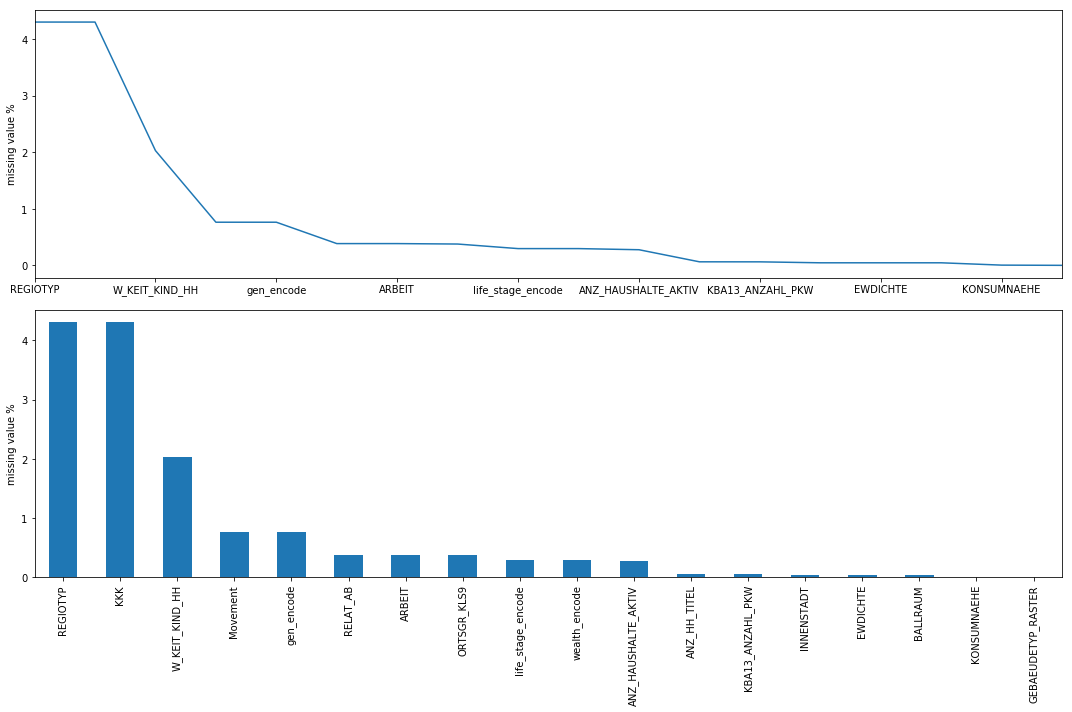

In [49]:
size = azdias.shape[0]
m = new_df.isnull().sum().sort_values(ascending = False)
m = m[m > 0]/(size)*100

plt.subplot(2,1,1)
m.plot(figsize=(15,10))
plt.ylabel('missing value %')
plt.subplot(2,1,2)
m.plot.bar(figsize=(15,10))
plt.ylabel('missing value %')
plt.tight_layout()

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [6]:
from sklearn.preprocessing import Imputer
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imp.fit(new_df)
ff = imputer.transform(new_df)
ff = pd.DataFrame(columns = new_df.columns, data = ff)
#sanity_check
ff.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
                        ..
CAMEO_DEU_2015_5A        0
CAMEO_DEU_2015_5B        0
CAMEO_DEU_2015_5C        0
CAMEO_DEU_2015_5D        0
CAMEO_DEU_2015_5E        0
CAMEO_DEU_2015_5F        0
C

In [7]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaler = scaler.fit(ff)
df = scaler.transform(ff)
df = pd.DataFrame(columns = new_df.columns, data = df)
#sanity_check
df.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,gen_encode,Movement,wealth_encode,life_stage_encode
0,-1.748,0.975,-1.524,1.589,-1.050,1.513,1.049,1.341,-0.543,1.039,...,-0.154,-0.163,-0.192,-0.180,-0.193,-0.084,1.164,0.549,-1.177,-1.264
1,0.193,0.975,-1.524,0.908,-1.771,-0.549,0.321,1.341,1.842,1.039,...,-0.154,-0.163,-0.192,-0.180,-0.193,-0.084,1.164,-1.839,0.871,0.751
2,0.193,-1.025,0.678,0.228,0.392,-1.236,0.321,-0.835,-0.543,1.039,...,-0.154,-0.163,-0.192,-0.180,-0.193,-0.084,-0.223,0.549,-0.495,0.079
3,-1.748,0.975,-0.056,-1.133,1.113,-0.549,-0.407,1.341,-0.543,1.039,...,-0.154,-0.163,-0.192,-0.180,-0.193,-0.084,-1.609,0.549,-1.177,0.751
4,-0.777,0.975,-1.524,1.589,-1.771,1.513,1.049,-0.110,-0.543,-0.286,...,-0.154,-0.163,-0.192,-0.180,-0.193,-0.084,0.471,0.549,0.871,-0.593


### Discussion 2.1: Apply Feature Scaling
- For imputation i used sklearn imputer with the mean to replace nan values, and to scale the dataframe i used the standard scaler for sklearn also.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [8]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

In [12]:
pca = PCA()
pca = pca.fit(df)

Text(0.5,1,'Explained Variance Per Principal Component')

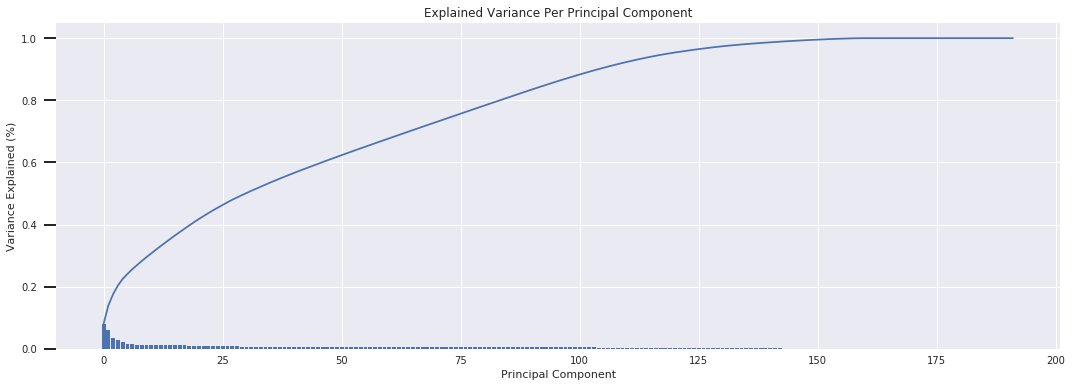

In [13]:
# Investigate the variance accounted for by each principal component.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(18, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.grid(True)
plt.title('Explained Variance Per Principal Component')

In [9]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 125)
pca = pca.fit(df)
df_pca = pca.transform(df)
df_pca.shape

(684502, 125)

### Discussion 2.2: Perform Dimensionality Reduction
- Looking at the graph above using 125 principal components aproximately 95% of the variance is explained, so based on these findings i decided to refit pca with 125 n_components without loosing too much variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [15]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def throw_weights(full_dataset, pca, dimension = None):
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    weights = components.iloc[dimension]
    return weights.sort_values(ascending = False)

In [16]:
throw_weights(new_df, pca, dimension = 0)

LP_STATUS_GROB_1.0      0.194
HH_EINKOMMEN_SCORE      0.184
PLZ8_ANTG3              0.180
PLZ8_ANTG4              0.174
ORTSGR_KLS9             0.151
EWDICHTE                0.149
FINANZ_HAUSBAUER        0.142
LP_STATUS_FEIN_1.0      0.129
KBA05_ANTG4             0.127
PLZ8_ANTG2              0.122
FINANZ_SPARER           0.121
KBA05_ANTG3             0.117
ANZ_HAUSHALTE_AKTIV     0.115
FINANZTYP_1             0.113
LP_STATUS_FEIN_2.0      0.113
ARBEIT                  0.112
CAMEO_DEUG_2015_9       0.112
Movement                0.108
RELAT_AB                0.104
CAMEO_DEUG_2015_8       0.091
LP_FAMILIE_GROB_1.0     0.089
LP_FAMILIE_FEIN_1.0     0.089
SEMIO_PFLICHT           0.088
gen_encode              0.085
SEMIO_REL               0.082
ZABEOTYP_5              0.081
SEMIO_RAT               0.076
SEMIO_TRADV             0.074
GFK_URLAUBERTYP_12.0    0.065
GEBAEUDETYP_3.0         0.065
                        ...  
SEMIO_ERL              -0.061
NATIONALITAET_KZ_1.0   -0.062
CAMEO_DEUG

In [17]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
throw_weights(new_df, pca, dimension = 1)

ALTERSKATEGORIE_GROB     0.232
FINANZ_VORSORGER         0.211
ZABEOTYP_3               0.199
SEMIO_ERL                0.184
SEMIO_LUST               0.163
RETOURTYP_BK_S           0.157
W_KEIT_KIND_HH           0.128
CJT_GESAMTTYP_2.0        0.103
LP_STATUS_FEIN_1.0       0.101
FINANZTYP_5              0.093
FINANZ_HAUSBAUER         0.092
FINANZTYP_2              0.084
SEMIO_KRIT               0.081
FINANZ_MINIMALIST        0.077
SHOPPER_TYP_3.0          0.074
PLZ8_ANTG3               0.074
PLZ8_ANTG4               0.070
EWDICHTE                 0.070
ORTSGR_KLS9              0.069
CJT_GESAMTTYP_1.0        0.068
LP_FAMILIE_FEIN_1.0      0.068
LP_FAMILIE_GROB_1.0      0.068
NATIONALITAET_KZ_1.0     0.065
FINANZTYP_6              0.063
SEMIO_KAEM               0.061
GFK_URLAUBERTYP_4.0      0.059
KBA05_ANTG4              0.057
ARBEIT                   0.053
PLZ8_ANTG2               0.051
ANZ_HAUSHALTE_AKTIV      0.051
                         ...  
PLZ8_GBZ                -0.056
ZABEOTYP

In [18]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
throw_weights(new_df, pca, dimension = 2)

SEMIO_VERT               0.321
SEMIO_FAM                0.259
SEMIO_SOZ                0.256
SEMIO_KULT               0.246
FINANZTYP_5              0.138
FINANZ_MINIMALIST        0.130
SHOPPER_TYP_0.0          0.124
SEMIO_REL                0.121
ZABEOTYP_1               0.117
RETOURTYP_BK_S           0.084
SEMIO_MAT                0.084
GREEN_AVANTGARDE         0.079
W_KEIT_KIND_HH           0.070
EWDICHTE                 0.066
ORTSGR_KLS9              0.065
LP_STATUS_FEIN_10.0      0.055
LP_STATUS_GROB_5.0       0.055
ZABEOTYP_6               0.050
PLZ8_ANTG4               0.049
FINANZ_VORSORGER         0.049
PLZ8_ANTG3               0.049
LP_STATUS_FEIN_3.0       0.045
LP_STATUS_FEIN_1.0       0.043
SHOPPER_TYP_1.0          0.042
PLZ8_ANTG2               0.036
RELAT_AB                 0.035
LP_STATUS_GROB_3.0       0.034
SEMIO_LUST               0.034
GEBAEUDETYP_3.0          0.032
ARBEIT                   0.031
                         ...  
LP_STATUS_GROB_2.0      -0.031
PLZ8_GBZ

### Discussion 2.3: Interpret Principal Components

- Using dimension 2 as an example, one can see that the first three features in this dimension have a big contrast with the last three, so a change in any of these features will end up affecting the other one in a very significant way.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [48]:
# Over a number of different cluster counts...
scores = []
centers = list(range(11,26))
for cluster in range(11,26):

    # run k-means clustering on the data and...
    model = KMeans(n_clusters = cluster)
    model = model.fit(df_pca)
    
    
    
    # compute the average within-cluster distances.
    scores.append(np.abs(model.score(df_pca)))    

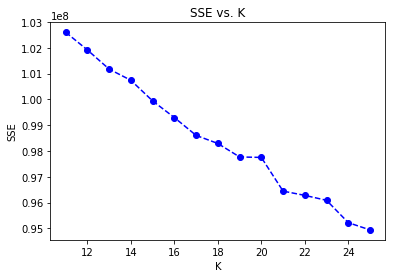

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [10]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters = 25)
model = model.fit(df_pca)

In [11]:
pred = model.predict(df_pca)

### Discussion 3.1: Apply Clustering to General Population
- By looking at the SSE vs k graph there is really no elbow rule to pick here from, so i decided to simply pick the last cluster that appeared on the graph which was 25.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [12]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.000,5,1,5,1,2,2,...,3.000,3.000,1.000,0.000,1.000,5.000,5.000,1.000,2.000,1.000
1,-1,4,1,nan,5,1,5,1,3,2,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,-1,4,2,2.000,5,1,5,1,4,4,...,2.000,3.000,3.000,1.000,3.000,3.000,2.000,3.000,5.000,3.000
3,1,4,1,2.000,5,1,5,2,1,2,...,3.000,2.000,1.000,0.000,1.000,3.000,4.000,1.000,3.000,1.000
4,-1,3,1,6.000,3,1,4,4,5,2,...,2.000,4.000,2.000,1.000,2.000,3.000,3.000,3.000,5.000,1.000


In [13]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df2 = clean_data1(customers, feat_info)
df2.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


(123748, 191)

In [14]:
#After doing the cleaning i noticed the one column difference between the two datasets, and after investigating 
#i discovered that the fifth level of GEBAEUDETYP does not exists in the customers dataset,
#so in order to continue i added the missing level

c1 = new_df.columns
c2 = df2.columns

for i in c1:
    if i not in c2:
        print(i)

GEBAEUDETYP_5.0


In [15]:
customers.shape

(191652, 85)

In [16]:
c_copy = customers.copy()
customers_new = pd.concat([c_copy, customers.iloc[-1:]])
customers_new.shape

(191653, 85)

In [17]:
customers_new['GEBAEUDETYP'].iloc[-1] = 5

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
df2 = clean_data1(customers_new, feat_info)
df2.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


(123749, 192)

In [19]:
ct = imputer.transform(df2)
ct = pd.DataFrame(columns = new_df.columns, data = ct)
df_ct = scaler.transform(ct)
df_ct = pd.DataFrame(columns = new_df.columns, data = df_ct)
df2_pca = pca.transform(df_ct)
df2_pca.shape

(123749, 125)

In [20]:
pred2 = model.predict(df2_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [21]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def cluster_prop(predictions):
    s_pred = pd.Series(predictions)
    pred_counts = s_pred.value_counts(normalize = True)
    ind = pred_counts.index.values
    pred_counts = pd.DataFrame(columns = ['Counts'], data = pred_counts.values, index = ind)
    pred_counts = pred_counts.assign(prop = lambda x: x/len(pred))
    return pred_counts

In [22]:
pred_df = cluster_prop(pred)
pred2_df = cluster_prop(pred2)

In [23]:
comparative_df = pd.DataFrame({'azdias_cluster_prop': pred_df.prop, 'customers_cluster_prop': pred2_df.prop,
                               'Cluster': range(0,25)})

Text(0.5,1,'Cluster Proportions')

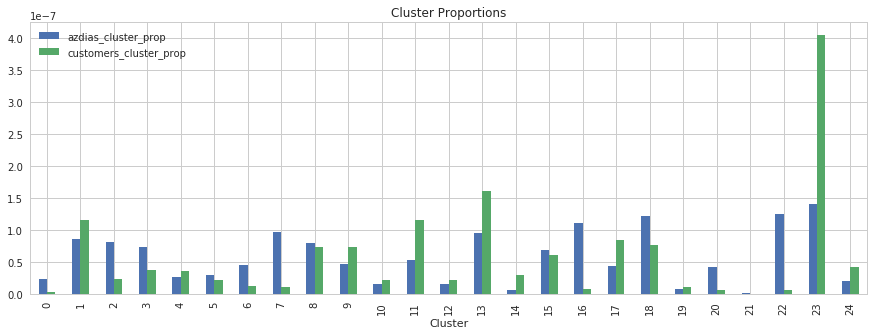

In [24]:
sns.set(style="whitegrid")
comparative_df.plot(x ='Cluster', y=['azdias_cluster_prop','customers_cluster_prop'], kind = 'bar', figsize = [15, 5])
plt.title('Cluster Proportions')

In [25]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

comparative_df1= comparative_df.assign(inside = lambda x: x['azdias_cluster_prop']-x['customers_cluster_prop'],
                                      outside = lambda x: x['customers_cluster_prop']-x['azdias_cluster_prop'])

In [26]:
comparative_df1 = comparative_df1.assign(new_inside = lambda x : x['inside']*10000000)
comparative_df1['new_inside'].sort_values()[:10]

23   -2.627
13   -0.653
11   -0.628
17   -0.394
1    -0.287
9    -0.268
14   -0.238
24   -0.219
4    -0.095
12   -0.059
Name: new_inside, dtype: float64

In [28]:
pca_cluster = df_pca[pred == 23]

inverse_pca = pca.inverse_transform(pca_cluster)
inverse_scale = scaler.inverse_transform(inverse_pca)
#
data = np.round(inverse_scale)
df3 = pd.DataFrame(data = data, columns = df.columns)
df3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,gen_encode,Movement,wealth_encode,life_stage_encode
0,3.000,1.000,5.000,2.000,3.000,1.000,3.000,2.000,1.000,3.000,...,-0.000,-0.000,-0.000,0.000,0.000,0.000,4.000,-0.000,3.000,4.000
1,2.000,1.000,4.000,4.000,2.000,3.000,4.000,1.000,1.000,1.000,...,-0.000,-0.000,-0.000,0.000,0.000,0.000,5.000,-0.000,5.000,4.000
2,2.000,1.000,5.000,4.000,2.000,3.000,4.000,1.000,1.000,3.000,...,0.000,0.000,0.000,-0.000,-0.000,-0.000,6.000,0.000,4.000,2.000
3,1.000,2.000,3.000,4.000,2.000,3.000,5.000,1.000,1.000,2.000,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,6.000,-0.000,2.000,3.000
4,4.000,2.000,5.000,1.000,5.000,1.000,2.000,3.000,0.000,2.000,...,0.000,-0.000,-0.000,0.000,0.000,0.000,2.000,1.000,3.000,3.000


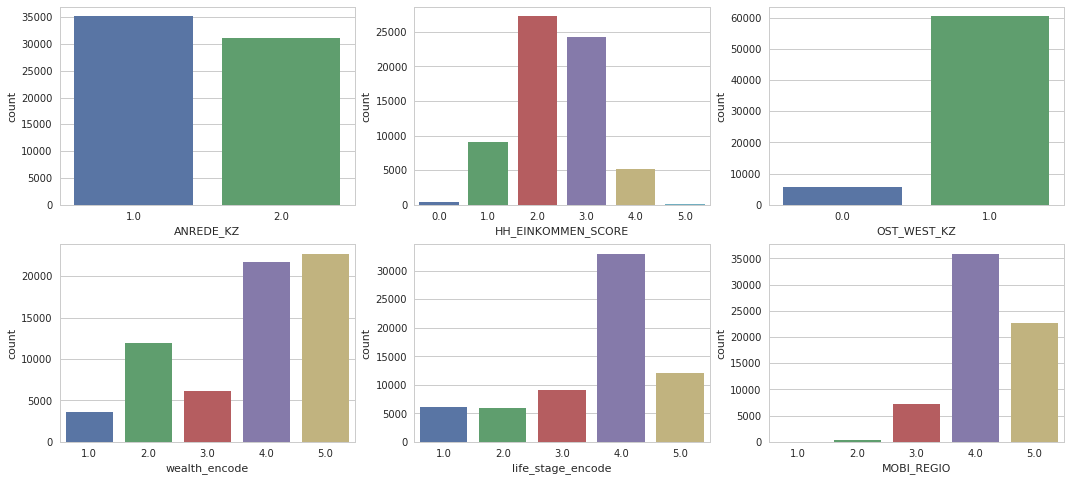

In [30]:
to_view = {'ANREDE_KZ': 'gender 1-male, 2,female',
           'HH_EINKOMMEN_SCORE':'Estimated household net income',
           'OST_WEST_KZ':'location', 
           'wealth_encode': 0, 
           'life_stage_encode':0, 
           'MOBI_REGIO':0}

fig, axs = plt.subplots(2,3, figsize=(18,8))
sns.countplot(df3['ANREDE_KZ'], ax = axs[0,0])
sns.countplot(df3['HH_EINKOMMEN_SCORE'], ax = axs[0,1])
sns.countplot(df3['OST_WEST_KZ'], ax = axs[0,2])
sns.countplot(df3['wealth_encode'], ax = axs[1,0])
sns.countplot(df3['life_stage_encode'], ax = axs[1,1])
sns.countplot(df3['MOBI_REGIO'], ax = axs[1,2])
plt.show()

In [31]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
comparative_df1['new_inside'].sort_values(ascending = False)[:10]


22   1.184
16   1.018
7    0.850
2    0.572
18   0.450
3    0.367
20   0.347
6    0.326
0    0.201
5    0.083
Name: new_inside, dtype: float64

In [32]:
pca_cluster = df_pca[pred == 22]

inverse_pca = pca.inverse_transform(pca_cluster)
inverse_scale = scaler.inverse_transform(inverse_pca)
#
data = np.round(inverse_scale)
df4 = pd.DataFrame(data = data, columns = df.columns)
df4.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,gen_encode,Movement,wealth_encode,life_stage_encode
0,1.000,2.000,1.000,5.000,2.000,5.000,4.000,5.000,-0.000,3.000,...,-0.000,0.000,0.000,0.000,-0.000,-0.000,6.000,1.000,1.000,1.000
1,2.000,2.000,1.000,5.000,1.000,5.000,5.000,4.000,-0.000,2.000,...,-0.000,0.000,0.000,0.000,-0.000,-0.000,6.000,1.000,4.000,2.000
2,1.000,2.000,1.000,5.000,2.000,5.000,4.000,5.000,0.000,3.000,...,0.000,-0.000,0.000,0.000,0.000,0.000,6.000,1.000,4.000,5.000
3,2.000,2.000,1.000,4.000,2.000,3.000,4.000,4.000,0.000,3.000,...,0.000,-0.000,-0.000,0.000,0.000,0.000,6.000,1.000,2.000,1.000
4,1.000,2.000,1.000,5.000,3.000,5.000,4.000,5.000,0.000,3.000,...,-0.000,0.000,0.000,-0.000,0.000,-0.000,6.000,1.000,2.000,1.000


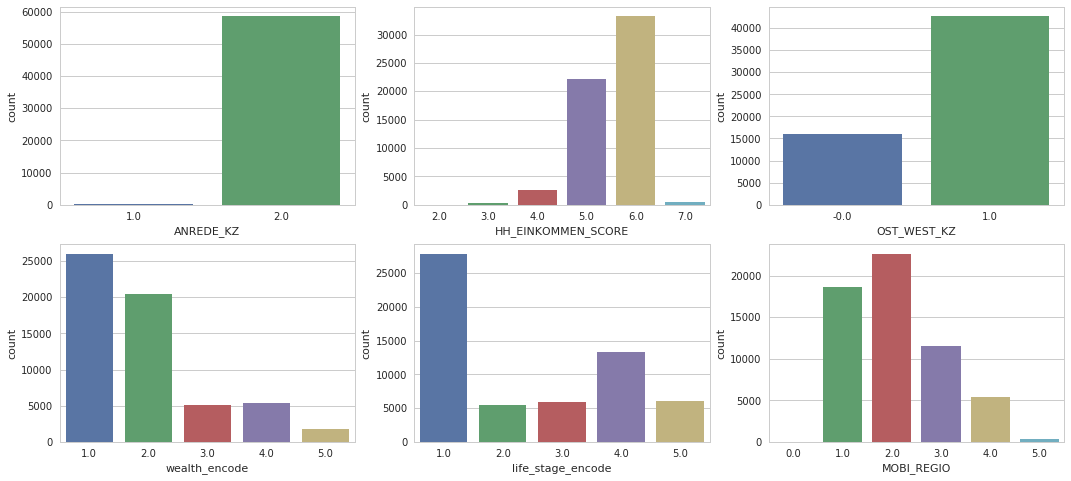

In [33]:
to_view = ['ANREDE_KZ','HH_EINKOMMEN_SCORE', 'OST_WEST_KZ', 'wealth_encode', 'life_stage_encode', 'MOBI_REGIO']

fig, axs = plt.subplots(2,3, figsize=(18,8))
sns.countplot(df4['ANREDE_KZ'], ax = axs[0,0])
sns.countplot(df4['HH_EINKOMMEN_SCORE'], ax = axs[0,1])
sns.countplot(df4['OST_WEST_KZ'], ax = axs[0,2])
sns.countplot(df4['wealth_encode'], ax = axs[1,0])
sns.countplot(df4['life_stage_encode'], ax = axs[1,1])
sns.countplot(df4['MOBI_REGIO'], ax = axs[1,2])
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

- For the analysis i picked ['ANREDE_KZ','HH_EINKOMMEN_SCORE', 'OST_WEST_KZ', 'wealth_encode', 'life_stage_encode', 'MOBI_REGIO'], because i believe they could give a good assesment overall of what the target must be for the mail campaign.

- Popular
    - Anrede_kz(gender): There is no clear weight for being either a man or a women.
    - Hh_einkommen_score(household net income): Persons with very high and high income are the ones to target for.
    - Ost_west_kz: Here one can see clearly the weight being in favor of west people.
    - wealth_encode: Wealthy and prosperous households are the ones to target for according to the cluster.
    - life_stage_encode : Mature to Elder couples have considerably more counts than young couples, meaning they belong to the business target
    - Mobu_regio : Target people that lives in one place ann moves very little to none
- Unpopular
    - With no surprise the unpopular side is the opposite of the results shown by the target cluster, the only anomaly or difference is that low income females are really not inside the target.

- Conclusion:
    - After the unsupervised learning analysis the ideal target for the mail campaign are mature/elder couples/persons/households that are settled in the city with little to no movement that lives in the west.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.